In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
data = pd.read_csv("Beds_Occupied.csv")
data.head()

,collection_date,Total Inpatient Beds
0,15-06-2020,293
1,16-06-2020,295
2,17-06-2020,290
3,18-06-2020,291
4,19-06-2020,288


In [3]:
data.shape

(359, 2)

In [4]:
data.describe()

,Total Inpatient Beds
count,359.000000
mean,241.983287
std,28.936836
min,190.000000
25%,219.000000
50%,235.000000
75%,259.000000
max,341.000000


## EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   collection_date       359 non-null    object
 1   Total Inpatient Beds  359 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


In [6]:
data.isnull().sum()

collection_date         0
Total Inpatient Beds    0
dtype: int64

<AxesSubplot:>

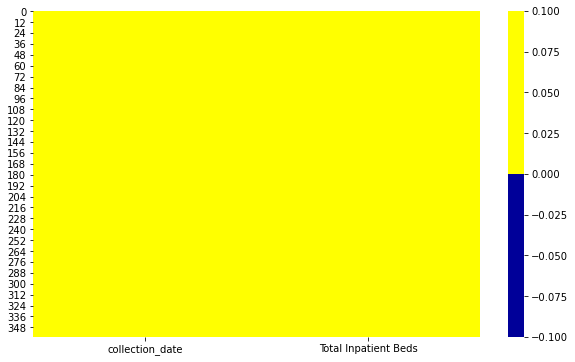

In [7]:
cols = data.columns 
colours = ['#000099', '#ffff00'] # specify the colours - yellow is not missing. blue is missing.
sns.heatmap(data[cols].isnull(),
            cmap=sns.color_palette(colours))

## There is no any null value present is data

## We will convert collection_date column to datetime format

In [8]:
data['collection_date'] =  pd.to_datetime(data['collection_date'],infer_datetime_format=True)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   collection_date       359 non-null    datetime64[ns]
 1   Total Inpatient Beds  359 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.7 KB


## From Dtype we can see that collection_date column is converted to datetime format.

## Since our objective is to forecast the data available and find out estimated beds available for the period of next one month. we will create one more column of Total available beds.

In [10]:
data['Total_available_beds'] = 900 - data['Total Inpatient Beds']
data.head()

,collection_date,Total Inpatient Beds,Total_available_beds
0,2020-06-15,293,607
1,2020-06-16,295,605
2,2020-06-17,290,610
3,2020-06-18,291,609
4,2020-06-19,288,612


In [11]:
data1 = data.drop(['Total Inpatient Beds'],axis=1)
data1.head()

,collection_date,Total_available_beds
0,2020-06-15,607
1,2020-06-16,605
2,2020-06-17,610
3,2020-06-18,609
4,2020-06-19,612


In [12]:
data1['collection_date'].duplicated().any()

False

## No any Duplicates present in Collection Date column

In [13]:
indexedDataset = data1.set_index(['collection_date'])

In [14]:
indexedDataset.describe()

,Total_available_beds
count,359.000000
mean,658.016713
std,28.936836
min,559.000000
25%,641.000000
50%,665.000000
75%,681.000000
max,710.000000


In [15]:
missing_dates=pd.date_range(start="2020-06-15", end="2021-06-15").difference(indexedDataset.index)
missing_dates

DatetimeIndex(['2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29',
               '2021-05-14', '2021-05-15', '2021-05-16'],
              dtype='datetime64[ns]', freq=None)

## There are 7 missing dates in our collection date column.we need to add them.

In [16]:
r = pd.date_range(start="2020-06-15", end="2021-06-15")
newdata=indexedDataset.reindex(r).rename_axis('collection_date').reset_index()
newdata.head()

,collection_date,Total_available_beds
0,2020-06-15,607.0
1,2020-06-16,605.0
2,2020-06-17,610.0
3,2020-06-18,609.0
4,2020-06-19,612.0


In [17]:
newdata.shape

(366, 2)

In [18]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   collection_date       366 non-null    datetime64[ns]
 1   Total_available_beds  359 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [19]:
newdata[newdata['Total_available_beds'].isnull()]

,collection_date,Total_available_beds
164,2020-11-26,NaN
165,2020-11-27,NaN
166,2020-11-28,NaN
167,2020-11-29,NaN
333,2021-05-14,NaN
334,2021-05-15,NaN
335,2021-05-16,NaN


## We can see that missing dates are added. so we have 366 non null values in collection date column.

## We will use Interpolation technique to fill NA values for newly added missing dates.

In [20]:
finaldata= newdata.interpolate(method='linear')

In [21]:
finaldata.head()

,collection_date,Total_available_beds
0,2020-06-15,607.0
1,2020-06-16,605.0
2,2020-06-17,610.0
3,2020-06-18,609.0
4,2020-06-19,612.0


## Outlier Detection

<AxesSubplot:>

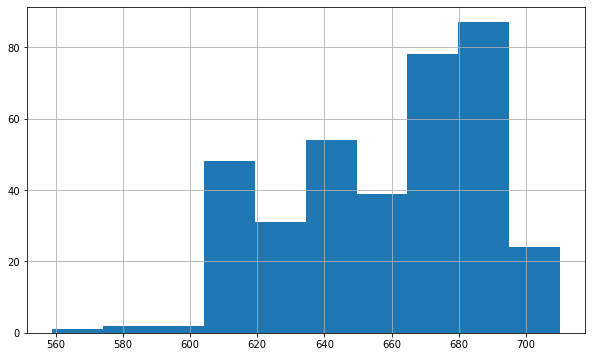

In [22]:
finaldata['Total_available_beds'].hist()

<AxesSubplot:>

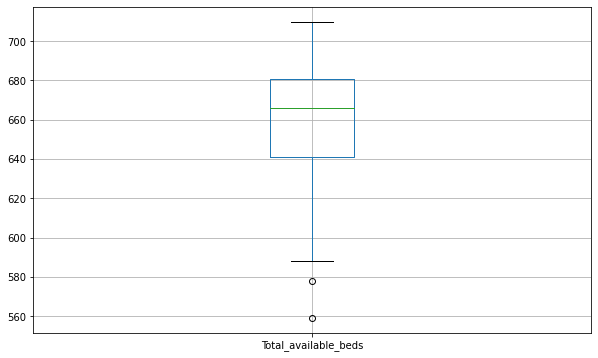

In [23]:
finaldata.boxplot(column='Total_available_beds')

## There are two outliers present 560 and 580. and they are at the lower side. so we can keep them as it is.

## Line plot

Text(0, 0.5, 'Available Beds')

<Figure size 1080x576 with 0 Axes>

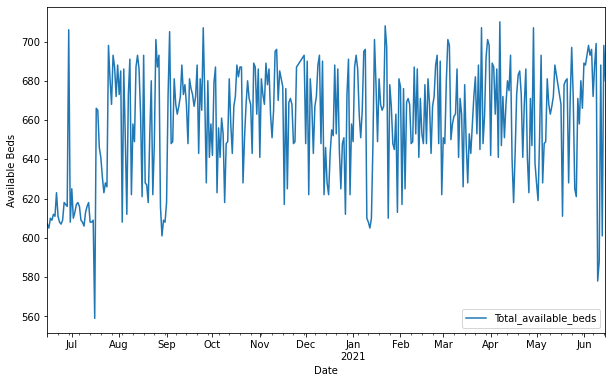

In [24]:
plt.figure(figsize=(15,8))
finaldata.plot(x = 'collection_date', y = 'Total_available_beds')
plt.xlabel('Date')
plt.ylabel('Available Beds')

## We will check if our data is stationary or having some trend or seasonality

In [25]:
rolmean = finaldata.rolling(window=8).mean() 
rolstd = finaldata.rolling(window=8).std()
print(rolmean,rolstd)

     Total_available_beds
0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
..                    ...
361                664.00
362                662.75
363                651.25
364                651.50
365                652.50

[366 rows x 1 columns]      Total_available_beds
0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
..                    ...
361             50.790888
362             49.950690
363             52.515984
364             52.763624
365             53.280927

[366 rows x 1 columns]


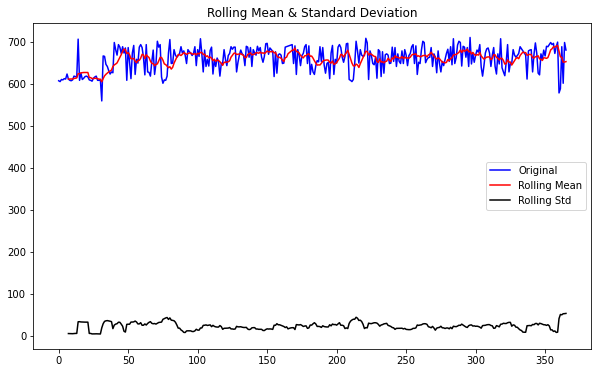

In [26]:
orig = plt.plot(finaldata['Total_available_beds'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## From above graph we can see that rolling mean and rolling std are constant over a time. so we can say that there is no any trend or seasonality present.

## Augmented Dickey–Fuller test:

In [27]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey Fuller Test:')
dftest = adfuller(finaldata['Total_available_beds'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -5.806344e+00
p-value                        4.507242e-07
#Lags Used                     4.000000e+00
Number of Observations Used    3.610000e+02
Critical Value (1%)           -3.448595e+00
Critical Value (5%)           -2.869580e+00
Critical Value (10%)          -2.571053e+00
dtype: float64


For a Time series to be stationary, its ADCF test should have:

1.p-value to be low (according to the null hypothesis)

2.The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics.

## From the above ADCF test result, we see that p-value is very low. Also critical values are close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is stationary.

## Time Series Decomposition plot

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

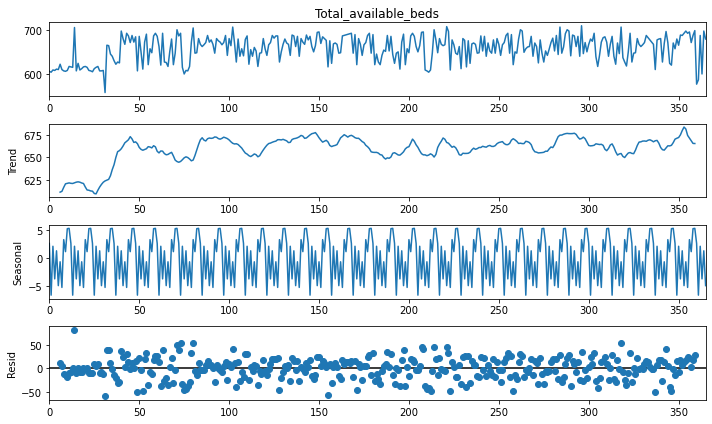

In [29]:
decompose_ts_add = seasonal_decompose(finaldata['Total_available_beds'],period=12)
decompose_ts_add.plot()
plt.show()

## ACF plots and PACF plots

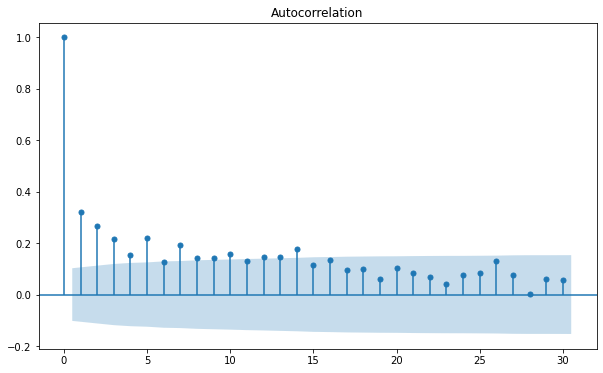

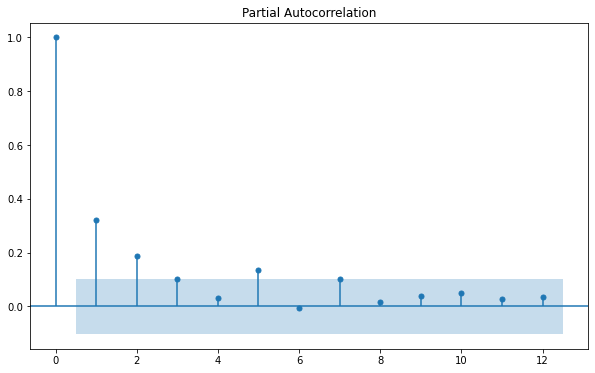

In [30]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(finaldata['Total_available_beds'],lags=30)
tsa_plots.plot_pacf(finaldata['Total_available_beds'],lags=12)
plt.show()


## Model Building

In [31]:
finaldata['t'] = range(1,367)
finaldata['tsqr'] = finaldata['t']**2
finaldata['log_Total_available_beds'] = np.log(finaldata['Total_available_beds'])
finaldata.head()

,collection_date,Total_available_beds,t,tsqr,log_Total_available_beds
0,2020-06-15,607.0,1,1,6.408529
1,2020-06-16,605.0,2,4,6.405228
2,2020-06-17,610.0,3,9,6.413459
3,2020-06-18,609.0,4,16,6.411818
4,2020-06-19,612.0,5,25,6.416732


In [32]:
#finaldata["month"] = finaldata.collection_date.dt.strftime("%b")
finaldata["day"] = finaldata.collection_date.dt.strftime("%A")

In [33]:
finaldata.head()

,collection_date,Total_available_beds,t,tsqr,log_Total_available_beds,day
0,2020-06-15,607.0,1,1,6.408529,Monday
1,2020-06-16,605.0,2,4,6.405228,Tuesday
2,2020-06-17,610.0,3,9,6.413459,Wednesday
3,2020-06-18,609.0,4,16,6.411818,Thursday
4,2020-06-19,612.0,5,25,6.416732,Friday


In [34]:
finaldata = pd.get_dummies(finaldata)

In [35]:
finaldata.head()

,collection_date,Total_available_beds,t,tsqr,log_Total_available_beds,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2020-06-15,607.0,1,1,6.408529,0,1,0,0,0,0,0
1,2020-06-16,605.0,2,4,6.405228,0,0,0,0,0,1,0
2,2020-06-17,610.0,3,9,6.413459,0,0,0,0,0,0,1
3,2020-06-18,609.0,4,16,6.411818,0,0,0,0,1,0,0
4,2020-06-19,612.0,5,25,6.416732,1,0,0,0,0,0,0


## Spliting data into train and test

In [36]:
train = finaldata.iloc[0:280,:]
test = finaldata.iloc[280:,:]

In [37]:
test.shape

(86, 12)

In [38]:
train.shape

(280, 12)

## RMSE function

In [39]:
def RMSE(org,pred):
    return np.sqrt(np.mean((np.array(org)-np.array(pred))**2))

## Linear Model

In [40]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Total_available_beds~t',data=train).fit()
pred_linear_test =  pd.Series(linear_model.predict(test['t']))

In [41]:
rmse_linear_test = RMSE(test['Total_available_beds'],pred_linear_test)
rmse_linear_test

29.92643932955416

In [42]:
pred_linear_train =  pd.Series(linear_model.predict(train['t']))
rmse_linear_train = RMSE(train['Total_available_beds'],pred_linear_train)
rmse_linear_train

27.468416368296637

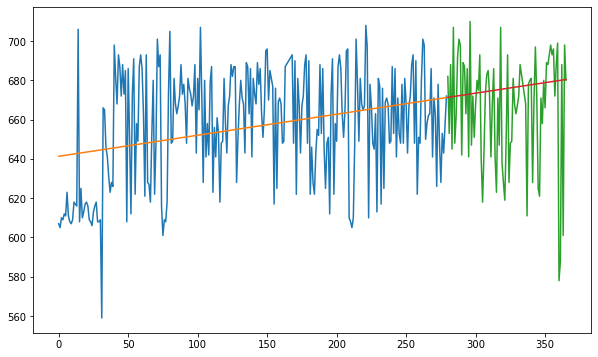

In [43]:
plt.plot(train['Total_available_beds'])
plt.plot(pred_linear_train)
plt.plot(test['Total_available_beds'])
plt.plot(pred_linear_test)


## Exponential Model

In [44]:
Exp = smf.ols('log_Total_available_beds~t',data=train).fit()
pred_Exp_test = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
pred_test = np.exp(pred_Exp_test)

In [45]:
rmse_exp_test=RMSE(test['Total_available_beds'],pred_test)
rmse_exp_test

30.04052449111536

In [46]:
pred_Exp_train = pd.Series(Exp.predict(pd.DataFrame(train['t'])))
pred_train = np.exp(pred_Exp_train)
rmse_exp_train =RMSE(train['Total_available_beds'],pred_train)
rmse_exp_train

27.495032098318195

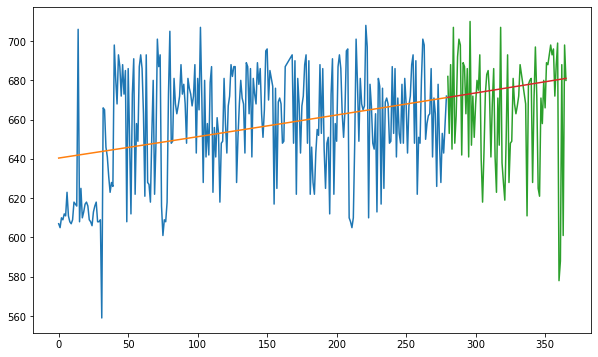

In [47]:
plt.plot(train['Total_available_beds'])
plt.plot(pred_train)
plt.plot(test['Total_available_beds'])
plt.plot(pred_test)

## Quadratic Model

In [48]:
Quad = smf.ols('Total_available_beds~t+tsqr',data=train).fit()
pred_Quad_test = pd.Series(Quad.predict(test[["t","tsqr"]]))

In [49]:
rmse_quad_test=RMSE(test['Total_available_beds'],pred_Quad_test)
rmse_quad_test

46.760221585968424

In [50]:
pred_Quad_train = pd.Series(Quad.predict(train[["t","tsqr"]]))
rmse_quad_train=RMSE(train['Total_available_beds'],pred_Quad_train)
rmse_quad_train

25.6732844546269

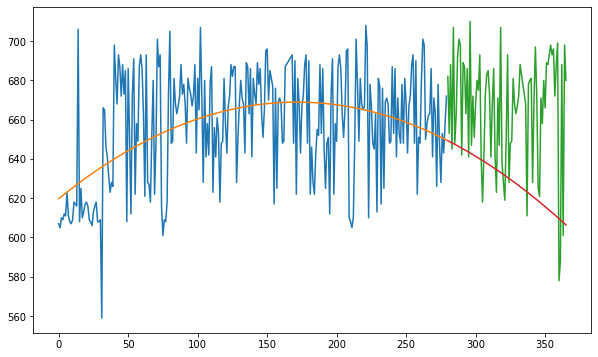

In [51]:
plt.plot(train['Total_available_beds'])
plt.plot(pred_Quad_train)
plt.plot(test['Total_available_beds'])
plt.plot(pred_Quad_test)

## Additive seasonality Model

In [52]:
add_sea = smf.ols('Total_available_beds~day_Monday+day_Tuesday+day_Wednesday+day_Thursday+day_Friday+day_Saturday',data=train).fit()
pred_add_sea_test = pd.Series(add_sea.predict(test[['day_Monday','day_Tuesday','day_Wednesday','day_Thursday','day_Friday','day_Saturday']]))

In [53]:
rmse_add_sea_test=RMSE(test['Total_available_beds'],pred_add_sea_test)
rmse_add_sea_test

29.83786178062256

In [54]:
pred_add_sea_train = pd.Series(add_sea.predict(train[['day_Monday','day_Tuesday','day_Wednesday','day_Thursday','day_Friday','day_Saturday']]))
rmse_add_sea_train=RMSE(train['Total_available_beds'],pred_add_sea_train)
rmse_add_sea_train

28.17351117881577

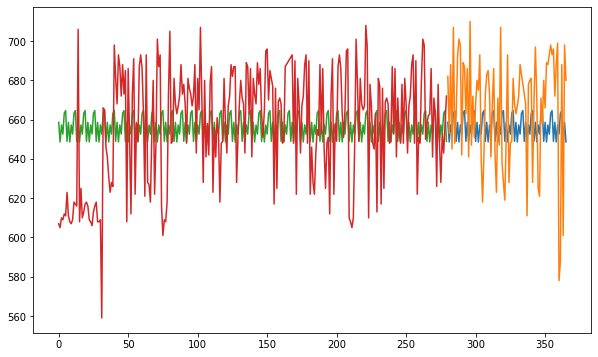

In [55]:
plt.plot(pred_add_sea_test)
plt.plot(test['Total_available_beds'])
plt.plot(pred_add_sea_train)
plt.plot(train['Total_available_beds'])

## Additive Seasonality Quadratic Model

In [56]:
add_sea_Quad = smf.ols('Total_available_beds~t+tsqr+day_Monday+day_Tuesday+day_Wednesday+day_Thursday+day_Friday+day_Saturday',data=train).fit()
pred_add_sea_quad_test = pd.Series(add_sea_Quad.predict(test[['day_Monday','day_Tuesday','day_Wednesday','day_Thursday','day_Friday','day_Saturday','t','tsqr']]))

In [57]:
rmse_add_sea_quad_test=RMSE(test['Total_available_beds'],pred_add_sea_quad_test)
rmse_add_sea_quad_test

47.04525955594231

In [58]:
pred_add_sea_quad_train = pd.Series(add_sea_Quad.predict(train[['day_Monday','day_Tuesday','day_Wednesday','day_Thursday','day_Friday','day_Saturday','t','tsqr']]))
rmse_add_sea_quad_train=RMSE(train['Total_available_beds'],pred_add_sea_quad_train)
rmse_add_sea_quad_train

24.971038017268114

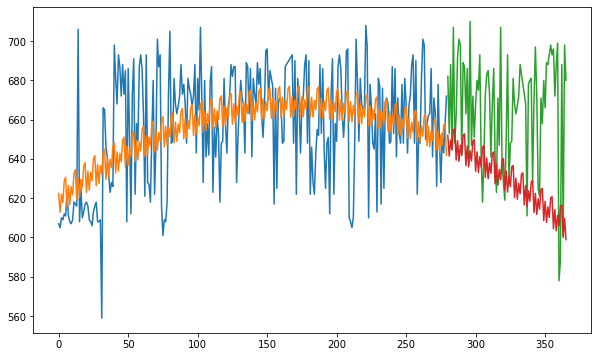

In [59]:
plt.plot(train['Total_available_beds'])
plt.plot(pred_add_sea_quad_train)
plt.plot(test['Total_available_beds'])
plt.plot(pred_add_sea_quad_test)

## Simple Exponential Method

In [60]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
ses_model = SimpleExpSmoothing(train["Total_available_beds"]).fit(smoothing_level=0.2)
pred_ses_test = ses_model.predict(start = test.index[0],end = test.index[-1])

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [61]:
rmse_ses_test=RMSE(test['Total_available_beds'],pred_ses_test)
rmse_ses_test

29.548455205271306

In [62]:
pred_ses_train = ses_model.predict(start = train.index[0],end = train.index[-1])
rmse_ses_train=RMSE(train['Total_available_beds'],pred_ses_train)
rmse_ses_train

25.69749255891434

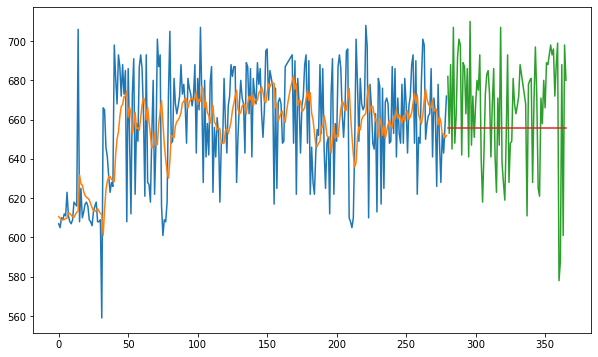

In [63]:
plt.plot(train['Total_available_beds'])
plt.plot(pred_ses_train)
plt.plot(test['Total_available_beds'])
plt.plot(pred_ses_test)

## Holts winter exponential smoothing with additive seasonality

In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hwe_model_add_sea = ExponentialSmoothing(train["Total_available_beds"],seasonal="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_sea_test = hwe_model_add_sea.predict(start = test.index[0],end = test.index[-1])


In [65]:
rmse_hwe_test=RMSE(test['Total_available_beds'],pred_hwe_add_sea_test)
rmse_hwe_test

30.32812599756513

In [66]:
pred_hwe_add_sea_train = hwe_model_add_sea.predict(start = train.index[0],end = train.index[-1])
rmse_hwe_train=RMSE(train['Total_available_beds'],pred_hwe_add_sea_train)
rmse_hwe_train

25.50598786750896

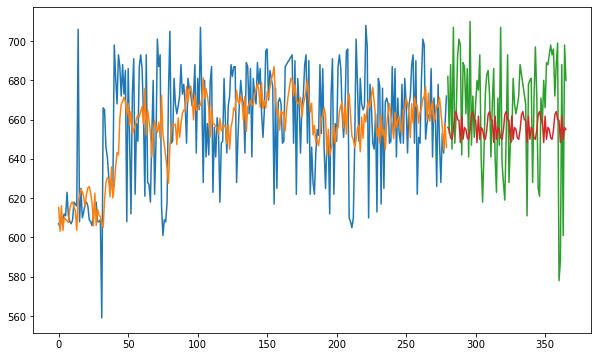

In [67]:
plt.plot(train['Total_available_beds'])
plt.plot(pred_hwe_add_sea_train)
plt.plot(test['Total_available_beds'])
plt.plot(pred_hwe_add_sea_test)

## ARIMA Model

## Plotting ACF & PACF 

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


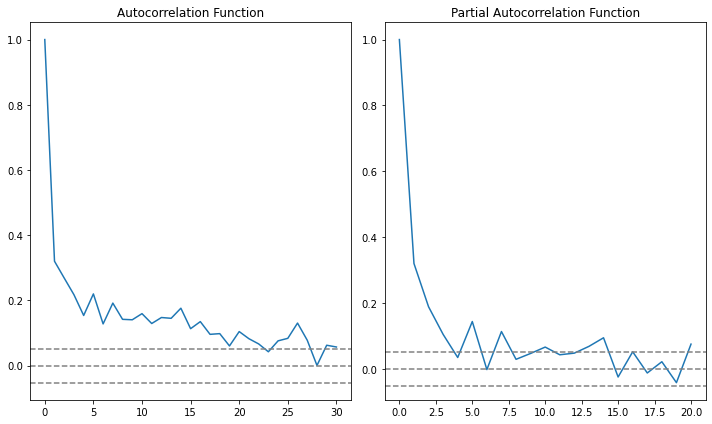

In [68]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(finaldata['Total_available_beds'], nlags=30)
lag_pacf = pacf(finaldata['Total_available_beds'], nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1/np.sqrt(len(finaldata)), linestyle='--', color='gray')
plt.axhline(y=1/np.sqrt(len(finaldata)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1/np.sqrt(len(finaldata)), linestyle='--', color='gray')
plt.axhline(y=1/np.sqrt(len(finaldata)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()  

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA ha

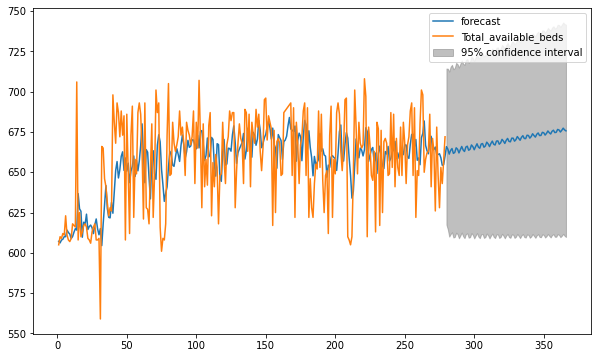

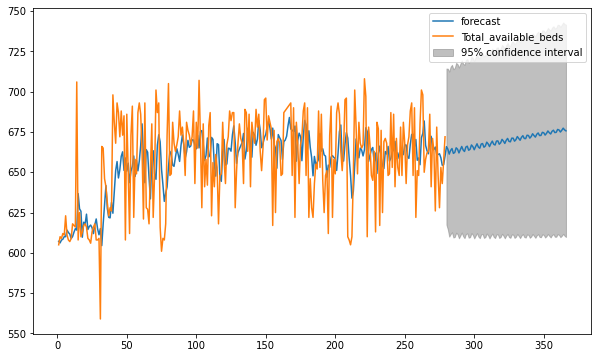

In [69]:
from statsmodels.tsa.arima_model import ARIMA
Arima_model = ARIMA(train['Total_available_beds'], order=(3,1,6)).fit()
forecast=Arima_model.forecast(steps=86)[0]
Arima_model.plot_predict(1, 366)

In [70]:
forecast_test = pd.Series(index=range(280,366),data=forecast)

In [71]:
arima_test = RMSE(test['Total_available_beds'], forecast)
arima_test

28.71146627162958

In [72]:
predictions_train = pd.Series(Arima_model.fittedvalues)
arima_train_predicted = train['Total_available_beds'].add(predictions_train,fill_value=0)


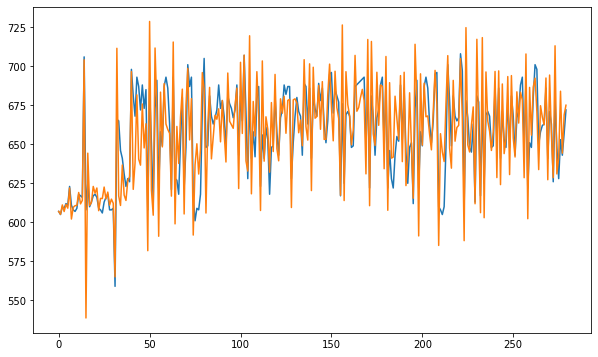

In [73]:
plt.plot(train['Total_available_beds'])
plt.plot(arima_train_predicted)


In [74]:
arima_train = RMSE(train['Total_available_beds'],arima_train_predicted)
arima_train

19.76336727289205

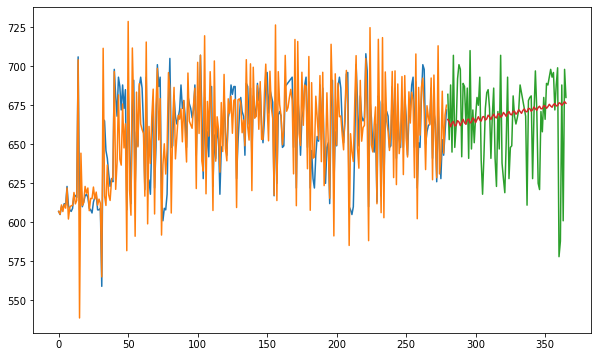

In [75]:
plt.plot(train['Total_available_beds'])
plt.plot(arima_train_predicted)
plt.plot(test['Total_available_beds'])
plt.plot(forecast_test)

## Model Evaluation

## compairing the results

In [76]:
data = {"MODEL":pd.Series(["Linear","exponential","quadratic","additive_seasonality","additive_seasonality_quadratic","simple_exponential","holt_winter_exp_add_seasonality","ARIMA"]),"RMSE_Test":pd.Series([rmse_linear_test,rmse_exp_test,rmse_quad_test,rmse_add_sea_test,rmse_add_sea_quad_test,rmse_ses_test,rmse_hwe_test,arima_test]),"RMSE_Train":pd.Series([rmse_linear_train,rmse_exp_train,rmse_quad_train,rmse_add_sea_train,rmse_add_sea_quad_train,rmse_ses_train,rmse_hwe_train,arima_train])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Test'])

,MODEL,RMSE_Test,RMSE_Train
7,ARIMA,28.711466,19.763367
5,simple_exponential,29.548455,25.697493
3,additive_seasonality,29.837862,28.173511
0,Linear,29.926439,27.468416
1,exponential,30.040524,27.495032
6,holt_winter_exp_add_seasonality,30.328126,25.505988
2,quadratic,46.760222,25.673284
4,additive_seasonality_quadratic,47.045260,24.971038


## From above table we can see that ARIMA model is giving less rmse 

## We will select ARIMA model for forecasting

In [77]:
Arima_model = ARIMA(finaldata['Total_available_beds'], order=(3,1,6)).fit()
forecast_final=Arima_model.forecast(steps=31)[0]

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA ha

In [78]:
date = pd.date_range(start="2021-06-16", end="2021-07-16")

In [79]:
forecast_beds = pd.DataFrame({'date':date,'available_beds':forecast_final})

In [80]:
forecast_beds

,date,available_beds
0,2021-06-16,668.608279
1,2021-06-17,677.358757
2,2021-06-18,659.274013
3,2021-06-19,673.332051
4,2021-06-20,668.207258
5,2021-06-21,664.059648
6,2021-06-22,671.248161
7,2021-06-23,669.779845
8,2021-06-24,663.915806
9,2021-06-25,672.185374


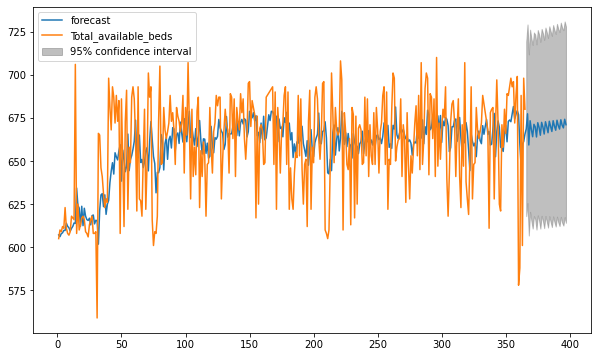

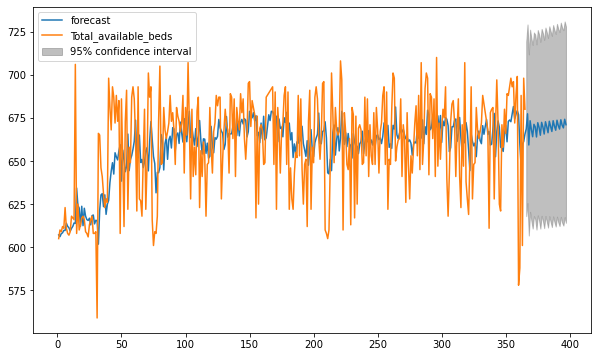

In [81]:
forecast_final=Arima_model.forecast(steps=31)[0]
Arima_model.plot_predict(1,397)


# SARIMA model